# ショアのアルゴリズム

## 歴史的背景

多くの計算問題は、入力となる問題の大きさに応じて計算量がどのように増大するかでアルゴリズムの性能を測ります。例えば、足し算のアルゴリズムは足す数字の大きさに応じて線形に計算量が増大しますが、中には入力の大きさに応じて計算量が指数関数的に成長するものもあります。こうした指数関数的に計算量が増大する計算問題は、地球上のどのコンピューターを使っても解けないほど大きくなることがあります。代表的な例としてインターネットのセキュリティは、解読に必要な計算問題が現実的な時間内では解決できないことによって担保されています。

そのような中1994年、ピーター・ショアは、量子コンピューター上で整数を効率的に素因数分解できることを示しました。[1]　これは大きなニュースです。 というのも、この問題を解く最良の古典アルゴリズムは、指数関数的に成長するアルゴリズムだからです。実際、先ほどの例の[RSA暗号](https://en.wikipedia.org/wiki/RSA_(cryptosystem))は、ある一定以上の大きな数を素因数分解することが不可能であることを前提にしてセキュリティを担保しています。

現在の古典コンピューターには大きすぎる整数を素因数分解するには何百万もの量子ビットとゲートが必要になりますが、これらの回路は現在の量子コンピューターで正常に動作させるにはまだ大きすぎます。  
では、Lieven M.K. Vandersypen、Matthias Steffen、Gregory Breyta、Costantino S. Yannoni、Mark H. Sherwood、Isaac L. Chuangは、2001年に量子コンピューターで15の因数分解をどうやって成功させたのでしょうか？[2]

ショアのアルゴリズムの回路を作る上での課題は $ay \bmod N$ を計算する回路を作ることです。多項式のゲート数で回路を作る方法は分かっていますが、現在のコンピューターではそれでも大きすぎます。一方で、問題に関する情報が事前にわかっていれば、ちょっと「ズル」をしてより効率的な回路を作ることができる場合があります。

上記の論文の著者は、他の多くの科学的進歩に加えて、$7y \bmod 15$ を実行する非常にシンプルな回路を発見しました。これにより、現状のハードウェアでも動作させるのに十分なサイズの回路ができました。今回のChallengeではショアのアルゴリズムに使用する $35y \bmod N$ の回路を作成してみましょう。

> 参考文献
> 1. Shor, Peter W. "Algorithms for quantum computation: discrete logarithms and factoring." Proceedings 35th annual symposium on foundations of computer science. Ieee, 1994.
> 1. Vandersypen, Lieven MK, et al. "Experimental realization of Shor's quantum factoring algorithm using nuclear magnetic resonance." Nature 414.6866 (2001): 883-887.

## ショアのアルゴリズムの概要

量子位相推定アルゴリズムは、ある量子状態にゲートをかけることで位相を求めてくれます。位相推定アルゴリズムの入力は、状態 $|1\rangle$ とゲート $Z$ であり、 $Z$ ゲートが状態 $|1\rangle$ に作用すると、同じ状態にグローバル位相 $\pi$ が追加された状態になります。

$$
Z|1\rangle = -|1\rangle = e^{i\pi} |1\rangle
$$

量子位相推定アルゴリズムがこれを解くための手法を提供します。  
ショアは、$U|y\rangle = |a y\bmod N\rangle$という振る舞いをするゲート$U$に対して位相推定を行うと、$N$の因子についての情報が得られることを示しました。

## Qiskitによるショアのアルゴリズム回路の作成

この課題では、$13y \bmod 35$ を実装した回路で位相推定を行い、35を因数分解します。ノーヒントで取り組みのは難しいので、まず最初にちょっとした「ズル」をしておきます。

ショアのアルゴリズムは、初期量子状態 $|1\rangle$ に $U$ を適用して到達できる状態でのみ動作すればよいので、このような動作をする回路であれば、どんな回路でも問題ありません。

$$
\begin{aligned}
U|1\rangle &= |13\rangle \\
UU|1\rangle &= |29\rangle \\
UUU|1\rangle &= |27\rangle \\
UUUU|1\rangle &= |1\rangle \\
\end{aligned}
$$

では、上記を簡単に行うにはどうすればよいのでしょうか。4つの異なる量子状態を正しく変換すればよいのですから、これを2量子ビットにエンコードすればよいことになります。今回の課題では、2量子ビットの計算基底の状態を、次のように数字にマッピングすることにします：

$$
\begin{aligned}
|1\rangle &\rightarrow |00\rangle \\
|13\rangle &\rightarrow |01\rangle \\
|29\rangle &\rightarrow |10\rangle \\
|27\rangle &\rightarrow |11\rangle \\
\end{aligned}
$$

なぜこれが「ズル」なのでしょう？なぜなら、この最適化を利用するためには、「$U$が影響を与える状態を事前にすべて知っておく必要がある」からです。つまり、再び1に戻るまで $ay \bmod N$ を計算して、 $a^x \bmod N$ の周期を把握しておくことで、 $N$ の因子を得ることができます。このように、周期の情報を使って最適化することは古典コンピューターでは解決できない問題には当然応用できません。

しかし、この課題の目的は、あくまで、ショアのアルゴリズムが意図したとおりに動作することを検証することであり、$U$の回路を得るためにちょっとしたズルを行ったという事実を気にするつもりはありません。

In [1]:
import qiskit
qiskit.__version__

'1.4.2'

### Exercise: $U$回路の作成
````{admonition} Exercise
下記の変換を行い、別の量子ビットによって制御される回路($U$)を作成してください。この回路は'target'という名前の2量子ビットのターゲットレジスタに作用し、'control'という名前の別の1量子ビットのレジスタによって制御されます。完成した回路を変数'`cu`'に割り当ててください。

$$
\begin{aligned}
U|00\rangle &= |01\rangle \\
U|01\rangle &= |10\rangle \\
U|10\rangle &= |11\rangle \\
U|11\rangle &= |00\rangle \\
\end{aligned}
$$

```python
from qiskit import QuantumCircuit
from qiskit import QuantumRegister, QuantumCircuit
c = QuantumRegister(1, 'control')
t = QuantumRegister(2, 'target')
cu = QuantumCircuit(c, t, name="Controlled 13^x mod 35")

# コードを記入ください - 開始





# コードを記入ください - 終了

cu.draw('mpl')
```
````

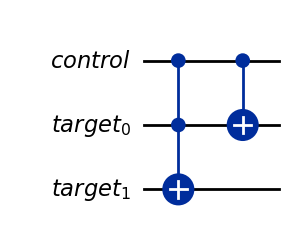

In [2]:
from qiskit import QuantumCircuit
from qiskit import QuantumRegister, QuantumCircuit
c = QuantumRegister(1, 'control')
t = QuantumRegister(2, 'target')
cu = QuantumCircuit(c, t, name="Controlled 13^x mod 35")

cu.ccx(c, t[0], t[1])
cu.cx(c, t[0])

cu.draw('mpl')

位相推定アルゴリズムの出力は量子ビットを測定して読み取るので、`counting`レジスタに $r$ を読み取るのに十分な量子ビットが存在する必要があります。ここでは、 $r=4$ なので、 $\log_2(4) = 2$ 個の量子ビットがあればよいことになります（$r$を事前に知っているのでここでもちょっとズルしています）。

$U$ の位相推定を行うためには、 $n$ 個の`counting`レジスタの各量子ビット（添字 $x$）に対して $U^{2^x}$ を実行する回路を作る必要があります。  
そのためには以下の3つの回路が必要になります：

$$ U, \; U^2, \; U^4 $$

そこで次は、$U^2$を実行する回路（つまり、$U$を2回適用することに相当する回路）を作ります。

### Exercise: $U^2$回路の作成
````{admonition} Exercise

下記の変換を行い、別の量子ビットによって制御される回路($U^2$)を作成してください。この回路は'target'という名前の2量子ビットのターゲットレジスタに作用し、'control'という名前の別の1量子ビットのレジスタによって制御されます。完成した回路を変数'`cu2`'に割り当ててください。

$$
\begin{aligned}
U|00\rangle &= |10\rangle \\
U|01\rangle &= |11\rangle \\
U|10\rangle &= |00\rangle \\
U|11\rangle &= |01\rangle \\
\end{aligned}
$$

```python
c = QuantumRegister(1, 'control')
t = QuantumRegister(2, 'target')
cu2 = QuantumCircuit(c, t)

# コードを記入ください - 開始





# コードを記入ください - 終了

cu2.draw('mpl')
```
````

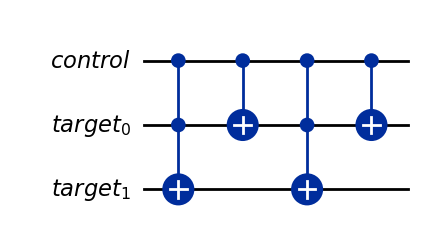

In [3]:
c = QuantumRegister(1, 'control')
t = QuantumRegister(2, 'target')
cu2 = QuantumCircuit(c, t)

cu2 = cu.compose(cu)

cu2.draw('mpl')

### Exercise: $U^4$回路の作成
````{admonition} Exercise
下記の変換を行い、別の量子ビットによって制御される回路($U^4$)を作成してください。この回路は'target'という名前の2量子ビットのターゲットレジスタに作用し、'control'という名前の別の1量子ビットのレジスタによって制御されます。完成した回路を変数'`cu4`'に割り当ててください。

ヒント：最適解はシンプルです。

$$
\begin{aligned}
U|00\rangle &= |00\rangle \\
U|01\rangle &= |01\rangle \\
U|10\rangle &= |10\rangle \\
U|11\rangle &= |11\rangle \\
\end{aligned}
$$

```python
c = QuantumRegister(1, 'control')
t = QuantumRegister(2, 'target')
cu4 = QuantumCircuit(c, t)

# コードを記入ください - 開始





# コードを記入ください - 終了

cu4.draw('mpl')
```
````

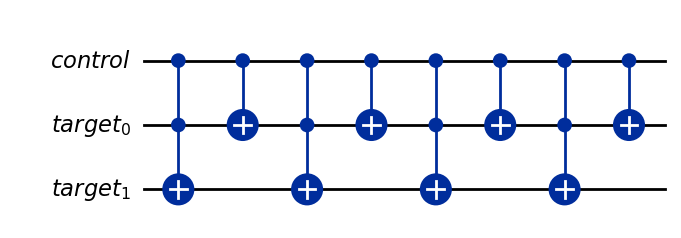

In [4]:
c = QuantumRegister(1, 'control')
t = QuantumRegister(2, 'target')
cu4 = QuantumCircuit(c, t)

cu4 = cu2.compose(cu2)

cu4.draw('mpl')

### Exercise: ショアのアルゴリズム回路の作成
````{admonition} Exercise

れで$U$, $U^2$, $U^4$を制御できるようになったので、これらを組み合わせてショアのアルゴリズムの量子部分を実行する回路を作ることができます。

初期化は簡単です。カウントレジスタを$|{+}{+}{+}\rangle$の状態にし（3つのHゲートで可能です）、ターゲットレジスタを$|1\rangle$の状態にします（計算基底の状態$|00\rangle$にマッピングしたので、ここでは何もする必要はありません）。ここまでの部分はこちらで作っておきます。

あなたの仕事は、初期化と逆量子フーリエ変換の間に使用される、制御された$U$を実行する回路を作ることです。より正確に記述すると、以下の回路を作っていただきたいと思います。

$$
CU_{c_0 t}CU^2_{c_1 t}CU^4_{c_2 t}
$$

ここで、$c_0$、$c_1$、$c_2$は'counting'レジスタの3つの量子ビット、$t$は'target'レジスタ、$U$はこの課題の最初の部分で定義したとおりです。この表記では、$CU_{a b}$は、$CU$が$a$によって制御され、$b$に作用することを意味します。この問題を解決する簡単な方法は、上で作成した回路 `cu`, `cu2`, `cu4` を単純に組み合わせることですが、おそらく同じ動作をするより効率的な回路を見つけることができるでしょう。

作成される回路には、CNOTしか使用できません。多量子ビットゲートは、1量子ビットゲートに比べて、ハードウェア上で実行するのが難しいため、あなたのスコアは使用したCNOTの数になります（少なければ少ないほどよい）。この条件の対応に戸惑いそうであれば、回路をこの形式に変換するコードを提出書類の横に記載しています。ただ、手計算の方が恐らくうまくいくでしょう。
````

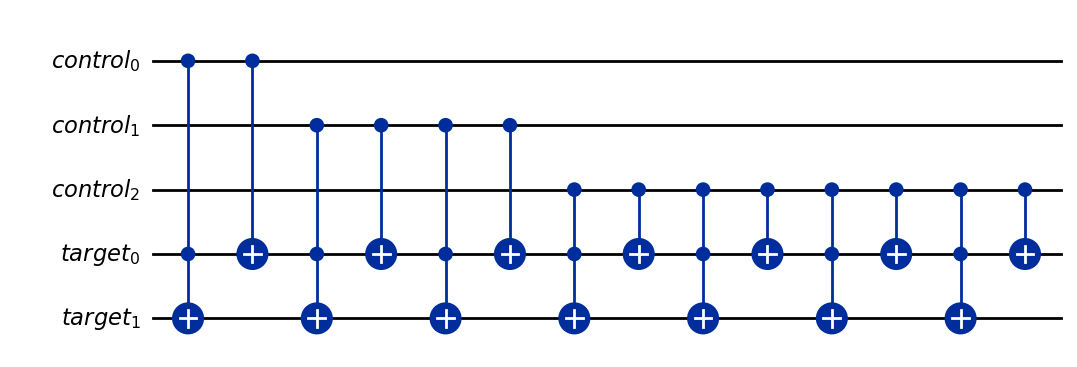

In [5]:
# これまでのソリューションを最終的な提出物にまとめるためのコード
cqr = QuantumRegister(3, 'control')
tqr = QuantumRegister(2, 'target')
cux = QuantumCircuit(cqr, tqr)
solutions = [cu, cu2, cu4]
for i in range(3):
    cux = cux.compose(solutions[i], [cqr[i], tqr[0], tqr[1]])
cux.draw('mpl')

おめでとうございます！あなたはこのチャレンジを終えました。あなたが作成した回路で、35を素因数分解されるのをみてみましょう。

## ショアのアルゴリズムで35を素因数分解する

以下のコードセルは $\tfrac{s}{r}$ を得るための回路を作成します。ここでは $s$ は $0$ と $r-1$ 間のランダムな整数であり、 $r$ は $f(x) = 13^x \bmod 35$ の周期になります。

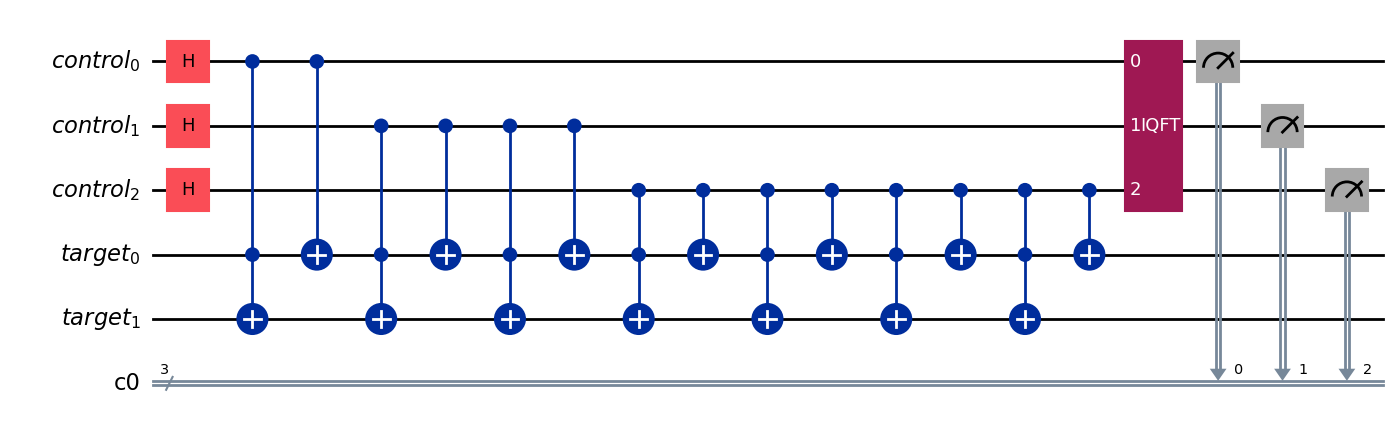

In [6]:
from qiskit.circuit.library import QFT
from qiskit import ClassicalRegister
# 回路オブジェクトの作成
cr = ClassicalRegister(3)
shor_circuit = QuantumCircuit(cqr, tqr, cr)

# 量子ビットの初期化
shor_circuit.h(cqr)

# 回路の追加
shor_circuit = shor_circuit.compose(cux)

# inverse QFT で出力を抽出
shor_circuit.append(QFT(3, inverse=True), cqr)
shor_circuit.measure(cqr, cr)
shor_circuit.draw('mpl')

この回路をトランスパイルして、回路がどのくらいの大きさで、何個のCNOTを使っているのか見てみましょう。

In [7]:
from qiskit import transpile
from qiskit.visualization import plot_histogram
from qiskit_aer import AerSimulator
sim = AerSimulator()
tqc = transpile(shor_circuit, sim, basis_gates=['u', 'cx'], optimization_level=3)
print(f"circuit depth: {tqc.depth()}")
print(f"Circuit contains {tqc.count_ops()['cx']} CNOTs")

circuit depth: 77
Circuit contains 41 CNOTs


結果をみてみましょう。

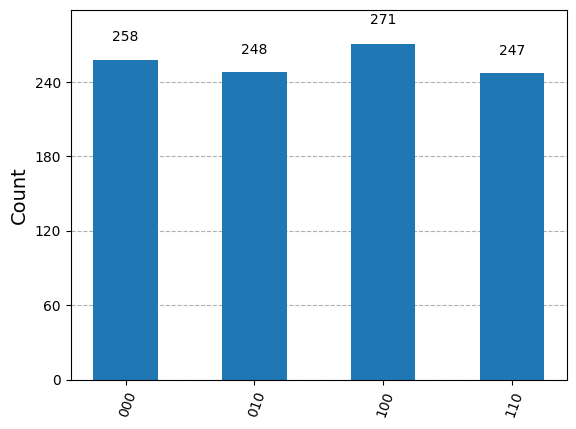

In [8]:
counts = sim.run(tqc).result().get_counts()
plot_histogram(counts)

すべてが正しく動作した場合は、 $0$, $2$, $4$, $6$ の数字を等確率で測定することができるはずです。 これは、位相推定によって、 $2^n \cdot \tfrac{s}{r}$ が得られるからです。  
ここで $n$ はカウントレジスタの量子ビット数（ここでは、$n = 3$）、 $s$ は$0$ から$r-1$の間のランダムな整数、 $r$は計算しようとしている数です。これを、$s/r$を表す分数に変換してみましょう。

In [9]:
from fractions import Fraction
n = cqr.size  # nは`counting`レジスタの量子ビットの数
# 各測定ストリングを循環させる
for measurement in counts.keys():
    # バイナリ文字列を`int`に変換して、2^nで割る
    decimal = int(measurement, 2)/2**n
    # 続分数のアルゴリズムを使用して、a/bの形式に変換します
    print(Fraction(decimal).limit_denominator())

1/4
0
3/4
1/2


いくつかの結果の分母を見れば、正解の周期は $r = 4$ がわかることがわかります。

In [10]:
13**4 % 35

1

では、ここからどうやって因数を求めたらよいでしょうか。  
$N$ と $a^{r/2}-1$ または $a^{r/2}+1$ の最大公約数が $N$ の因数である可能性が高く、最大公約数も古典的に簡単に計算できることを利用します。

In [11]:
from math import gcd # greatest common divisor
for x in [-1, 1]:
    print(f"Guessed factor: {gcd(13**(4//2)+x, 35)}")

Guessed factor: 7
Guessed factor: 5


これにより、1つの因数を見つければそれを使って $N$ を割ることでもう1つの因数を見つけることができます。  
しかし、この場合は、 $a^{r/2}-1$ と $a^{r/2}+1$ のどちらも $35$ の因数を与えます。これが正しいかどうか確認してください。

## ハードウェアでの実行
この例では、便宜上Santiagoをシミュレーションしたデバイスを使用していますが、必要に応じて実際のデバイスに切り替えることができます。

In [12]:
# from qiskit.test.mock import FakeSantiago
# from qiskit import assemble
# from qiskit.visualization import plot_histogram
# santiago = FakeSantiago()
# real_device = False

# ## 実機でコードを走らせるときは以下のコメントアウトを解除
# #from qiskit import IBMQ
# #IBMQ.load_account()
# #provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')
# #santiago = provider.get_backend('ibmq_santiago')
# #real_device = True

# # Santiago上での実行のために回路をトランスパイルする
# tqc = transpile(shor_circuit, santiago, optimization_level=3)

# if not real_device:
#     tqc = assemble(tqc)

# # 回路の実行とカウントの表示
# counts = santiago.run(tqc).result().get_counts()
# plot_histogram(counts)

スコアが十分に低ければ、完璧なシミュレーションで見たように、0$、2$、4$、8$を測定する確率が高いことがわかります。プロセッサの不正確さや量子ビットと相互作用する不要なもののために、いくつかの余分な結果が表示されます。この「ノイズ」は、回路が長くなればなるほど悪化します。計算時間が長くなればなるほど、不要な相互作用の時間が長くなり、ゲート数が増えれば増えるほど、潜在的なエラーが増えるからです。そのため、できるだけ小さな回路を作るためにズルをする必要がありました。


近い将来、私たちの量子システムは、これらの問題を克服するために、より高度なエラー抑制技術を使い始めることができるまでに改善されるでしょう。そうなれば、[ズルをせずにショアのアルゴリズムを実行できる](https://arxiv.org/pdf/quant-ph/0205095.pdf)ほどの大規模な回路を走らせることができるようになります。